In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv2D, Reshape, Dropout, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.activations import relu, elu, linear
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


Using TensorFlow backend.


In [2]:
from os import listdir
from os.path import isfile, join
hotdogs_train = [f for f in listdir("../data/train/hot_dog/") if isfile(join("../data/train/hot_dog/", f))]
hotdogs_test = [f for f in listdir("../data/test/hot_dog/") if isfile(join("../data/test/hot_dog/", f))]
not_hotdogs_train = [f for f in listdir("../data/train/not_hot_dog/") if isfile(join("../data/train/not_hot_dog/", f))]
not_hotdogs_test = [f for f in listdir("../data/test/not_hot_dog/") if isfile(join("../data/test/not_hot_dog/", f))]

In [3]:
import PIL
from PIL import Image

In [4]:
X_train = np.zeros((498, 200, 200, 3))
X_test = np.zeros((500, 200, 200, 3))
Y_train = np.zeros(498)
Y_test = np.zeros(500)

for i in trange(249):
    filename = hotdogs_train[i]
    img = Image.open(f"../data/train/hot_dog/{filename}")
    x, y = img.size
    cropsize = min(x, y)
    img = img.crop((x//2 - cropsize//2, y//2 - cropsize//2, x//2 + cropsize//2, y//2 + cropsize//2))
    img = img.resize((200, 200), PIL.Image.BICUBIC)
    X_train[i] = np.array(img)/255
    Y_train[i] = 1
    
for i in trange(249):
    filename = not_hotdogs_train[i]
    img = Image.open(f"../data/train/not_hot_dog/{filename}")
    x, y = img.size
    cropsize = min(x, y)
    img = img.crop((x//2 - cropsize//2, y//2 - cropsize//2, x//2 + cropsize//2, y//2 + cropsize//2))
    img = img.resize((200, 200), PIL.Image.BICUBIC)
    X_train[249 + i] = np.array(img)/255
    Y_train[249 + i] = 0

for i in trange(250):
    filename = hotdogs_test[i]
    img = Image.open(f"../data/test/hot_dog/{filename}")
    x, y = img.size
    cropsize = min(x, y)
    img = img.crop((x//2 - cropsize//2, y//2 - cropsize//2, x//2 + cropsize//2, y//2 + cropsize//2))
    img = img.resize((200, 200), PIL.Image.BICUBIC)
    X_test[i] = np.array(img)/255
    Y_test[i] = 1
    
for i in trange(250):
    filename = not_hotdogs_test[i]
    img = Image.open(f"../data/test/not_hot_dog/{filename}")
    x, y = img.size
    cropsize = min(x, y)
    img = img.crop((x//2 - cropsize//2, y//2 - cropsize//2, x//2 + cropsize//2, y//2 + cropsize//2))
    img = img.resize((200, 200), PIL.Image.BICUBIC)
    X_test[250 + i] = np.array(img)/255
    Y_test[250 + i] = 0

100%|██████████| 250/250 [00:01<00:00, 206.67it/s]


In [5]:
train_shuffle = np.arange(498)
np.random.shuffle(train_shuffle)
test_shuffle = np.arange(500)
np.random.shuffle(test_shuffle)

In [6]:
X_train = X_train[train_shuffle]; X_test = X_test[test_shuffle]
Y_train = Y_train[train_shuffle]; Y_test = Y_test[test_shuffle]

(<matplotlib.image.AxesImage at 0x7f15e0da1a50>, 0.0)

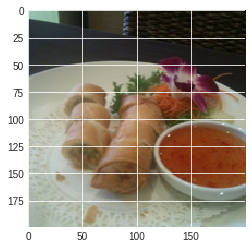

In [7]:
plt.imshow(X_train[53]), Y_train[53]

In [8]:
Y_onehot_train = np_utils.to_categorical(Y_train)
Y_onehot_test = np_utils.to_categorical(Y_test)

In [9]:
opti = optimizers.Adam(amsgrad=True, lr=1e-3)
def nn_clf():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (7,7), padding = 'Same', activation ='relu', input_shape = (200,200,3)))
    model.add(MaxPool2D(pool_size=(4,4)))
    
    model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(4,4)))

    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(4,4)))
    
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(2, activation = "softmax"))
    
    model.compile(optimizer=opti, loss="categorical_crossentropy",  metrics=["accuracy"])
    return model
nn_clf().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [10]:
callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
clf = KerasClassifier(build_fn=nn_clf, batch_size=64, epochs=200, validation_data=(X_test, Y_onehot_test), callbacks=callbacks, verbose=1)
history = clf.fit(X_train, Y_onehot_train)

Train on 498 samples, validate on 500 samples
Epoch 1/200
498/498 [==============================] - 15s 30ms/step - loss: 0.7006 - accuracy: 0.4839 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 2/200
498/498 [==============================] - 15s 30ms/step - loss: 0.6958 - accuracy: 0.4618 - val_loss: 0.6927 - val_accuracy: 0.5340
Epoch 3/200
498/498 [==============================] - 15s 30ms/step - loss: 0.6921 - accuracy: 0.5803 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/200
498/498 [==============================] - 15s 30ms/step - loss: 0.6890 - accuracy: 0.5663 - val_loss: 0.6942 - val_accuracy: 0.5060
Epoch 5/200
498/498 [==============================] - 15s 30ms/step - loss: 0.6741 - accuracy: 0.5803 - val_loss: 0.6927 - val_accuracy: 0.5400
Epoch 6/200
498/498 [==============================] - 16s 32ms/step - loss: 0.6821 - accuracy: 0.5602 - val_loss: 0.6882 - val_accuracy: 0.5480
Epoch 7/200
498/498 [==============================] - 18s 36ms/step - loss: 0.6769 